In [1]:
# import Pkg
# Pkg.add("DifferentialEquations")
# Pkg.add("Plots")
# Pkg.add("DataFrames")
# Pkg.add("ModelingToolkit")
# Pkg.add("LSODA")
# Pkg.add("BenchmarkTools")
# Pkg.add("DataFrames")
# Pkg.add("CSV")

In [2]:
using DifferentialEquations
using DataFrames: DataFrame
using CSV: File as CSVFile

In [3]:
using Plots
using BenchmarkTools

In [4]:
include("../src/julia_scripts/INa/src/INa.jl")  # run_model

Main.INa

In [5]:
dirname_model = "../src/model_ctypes/ina_pipette/"

filename_legend_constants = Base.Filesystem.joinpath(dirname_model, "legend_constants.csv")
filename_legend_states = Base.Filesystem.joinpath(dirname_model, "legend_test.csv")
filename_protocol = Base.Filesystem.joinpath("../data/protocols/protocol_sparse.csv");

In [6]:
legend_states = DataFrame(CSVFile(filename_legend_states))
legend_constants = DataFrame(CSVFile(filename_legend_constants))
protocol = DataFrame(CSVFile(filename_protocol));

In [7]:
sol = INa.run_model(legend_constants, protocol);

In [8]:
@benchmark INa.run_model(legend_constants, protocol)

BenchmarkTools.Trial: 13 samples with 1 evaluation.
 Range (min … max):  393.801 ms … 423.796 ms  ┊ GC (min … max): 0.00% … 2.85%
 Time  (median):     406.306 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   407.311 ms ±   8.656 ms  ┊ GC (mean ± σ):  1.03% ± 1.58%

  █    █    █    █  █     ██       ██   █ █       █           █  
  █▁▁▁▁█▁▁▁▁█▁▁▁▁█▁▁█▁▁▁▁▁██▁▁▁▁▁▁▁██▁▁▁█▁█▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁█ ▁
  394 ms           Histogram: frequency by time          424 ms <

 Memory estimate: 35.66 MiB, allocs estimate: 391417.

# Analysis

In [9]:
function affect!(integrator)
    t = integrator.t
    v_c = INa.find_step(t, protocol)
    index_v_c = findfirst(isequal("v_c"), legend_constants.name)
    legend_constants[index_v_c, :].value = v_c
    p = INa.create_p_from_legend(legend_constants)
    integrator.p = p
    set_proposed_dt!(integrator, 1e-9)
    nothing
end

cb = PresetTimeCallback(protocol.t, affect!)

DiscreteCallback{DiffEqCallbacks.var"#59#62"{Vector{Float64}}, DiffEqCallbacks.var"#60#63"{typeof(affect!)}, DiffEqCallbacks.var"#61#64"{typeof(DiffEqBase.INITIALIZE_DEFAULT), Bool, Vector{Float64}, typeof(affect!)}, typeof(DiffEqBase.FINALIZE_DEFAULT)}(DiffEqCallbacks.var"#59#62"{Vector{Float64}}([0.0, 0.00395, 0.05395, 0.25395, 0.30395, 0.35395, 0.45395, 0.50395, 0.55395, 0.60395  …  4.45395, 4.5039500000000015, 4.55395, 4.60395, 4.70395, 4.7539500000000015, 4.80395, 4.85395, 4.95395, 4.99995]), DiffEqCallbacks.var"#60#63"{typeof(affect!)}(affect!), DiffEqCallbacks.var"#61#64"{typeof(DiffEqBase.INITIALIZE_DEFAULT), Bool, Vector{Float64}, typeof(affect!)}(DiffEqBase.INITIALIZE_DEFAULT, true, [0.0, 0.00395, 0.05395, 0.25395, 0.30395, 0.35395, 0.45395, 0.50395, 0.55395, 0.60395  …  4.45395, 4.5039500000000015, 4.55395, 4.60395, 4.70395, 4.7539500000000015, 4.80395, 4.85395, 4.95395, 4.99995], affect!), DiffEqBase.FINALIZE_DEFAULT, Bool[1, 1])

In [10]:
p = INa.create_p_from_legend(legend_constants)
func = ODEFunction(INa.compute_rates!, syms=[:I_out])
u₀ = [-80.0, -80.0, -80.0, 0.0, 1.0, 1.0, 0.0]
tspan = protocol.t[[1, end]]

prob = ODEProblem(func, u₀, tspan, p,
                  callback=cb);

In [11]:
saveat = 0: 5e-5: 5
reltol = 1e-9
abstol = 1e-9

sol = solve(prob, alg=Rodas4(), reltol=reltol, abstol=abstol, saveat=saveat, save_idxs=[7]);

In [12]:
sol.alg

Rodas4{7, true, DefaultLinSolve, Val{:forward}}(DefaultLinSolve(nothing, nothing, nothing))

In [13]:
@benchmark solve(prob, alg=sol.alg, reltol=reltol, abstol=abstol)

BenchmarkTools.Trial: 12 samples with 1 evaluation.
 Range (min … max):  402.846 ms … 492.056 ms  ┊ GC (min … max): 0.00% … 9.10%
 Time  (median):     429.141 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   437.605 ms ±  28.556 ms  ┊ GC (mean ± σ):  3.42% ± 4.04%

  █  █ █     █   █ ██   █                 █ █    █            █  
  █▁▁█▁█▁▁▁▁▁█▁▁▁█▁██▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁█▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  403 ms           Histogram: frequency by time          492 ms <

 Memory estimate: 67.23 MiB, allocs estimate: 560169.

In [14]:
@benchmark solve(prob, alg=sol.alg, reltol=reltol, abstol=abstol, saveat=saveat)

BenchmarkTools.Trial: 13 samples with 1 evaluation.
 Range (min … max):  389.980 ms … 424.872 ms  ┊ GC (min … max): 0.00% … 4.33%
 Time  (median):     399.414 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   405.461 ms ±  13.830 ms  ┊ GC (mean ± σ):  1.25% ± 1.89%

  █ █ ███       █ █        █                    █     █    ██ █  
  █▁█▁███▁▁▁▁▁▁▁█▁█▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁█▁▁▁▁██▁█ ▁
  390 ms           Histogram: frequency by time          425 ms <

 Memory estimate: 40.23 MiB, allocs estimate: 391248.

In [15]:
@benchmark solve(prob, alg=sol.alg, reltol=reltol, abstol=abstol, saveat=saveat, save_idxs=[7])

BenchmarkTools.Trial: 13 samples with 1 evaluation.
 Range (min … max):  388.664 ms … 423.257 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     403.315 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   402.825 ms ±  10.123 ms  ┊ GC (mean ± σ):  0.85% ± 1.59%

  █       ▁     ▁  ▁  ▁    ▁  ▁▁  ▁     ▁         ▁           ▁  
  █▁▁▁▁▁▁▁█▁▁▁▁▁█▁▁█▁▁█▁▁▁▁█▁▁██▁▁█▁▁▁▁▁█▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁█ ▁
  389 ms           Histogram: frequency by time          423 ms <

 Memory estimate: 35.65 MiB, allocs estimate: 391250.

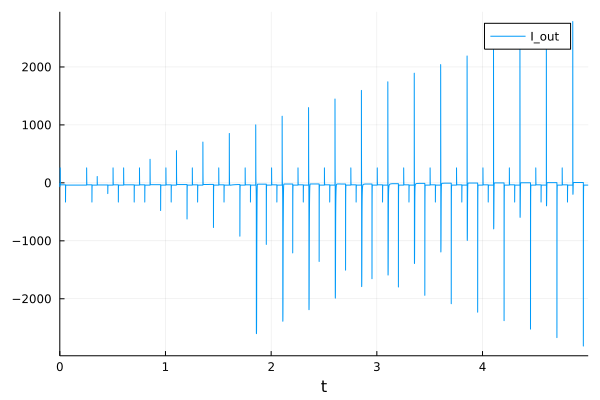

In [16]:
plot(sol)

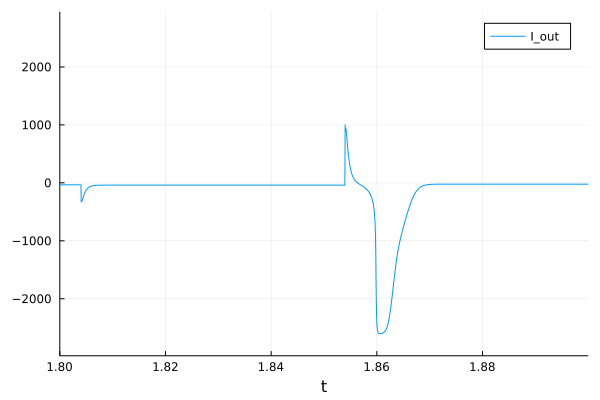

In [17]:
plot(sol)
plot!(xlims=(1.8, 1.9))
# plot!(xlims=(2.8, 2.9))

In [18]:
sol

retcode: Success
Interpolation: 1st order linear
t: 100093-element Vector{Float64}:
 0.0
 5.0e-5
 0.0001
 0.00015
 0.0002
 0.00025
 0.0003
 0.00035
 0.0004
 0.00045
 0.0005
 0.00055
 0.0006
 ⋮
 4.99945
 4.9995
 4.99955
 4.9996
 4.99965
 4.9997
 4.99975
 4.9998
 4.99985
 4.9999
 4.99995
 4.99995
u: 100093-element Vector{Vector{Float64}}:
 [0.0]
 [-30.837127098809965]
 [-48.323558808378955]
 [-57.80710945298995]
 [-62.524376170903295]
 [-64.43181638282888]
 [-64.7098606171263]
 [-64.06868093096784]
 [-62.933640755389185]
 [-61.557758173703604]
 [-60.08989622502812]
 [-58.61609826817517]
 [-57.18463473927094]
 ⋮
 [-38.99389186058511]
 [-38.99389186071694]
 [-38.99389186084881]
 [-38.99389186098069]
 [-38.99389186111267]
 [-38.99389186124475]
 [-38.993891861376895]
 [-38.9938918615091]
 [-38.993891861641345]
 [-38.99389186177361]
 [-38.99389186190589]
 [-38.99389186190589]